## Zaidel Problem

Described in Zaidel (2013), representing a discontinuous
water table configuration over a stairway impervious base.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-zaidel"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Scenario-specific parameters
parameters = {
    "ex-gwf-zaidel-p01a": {
        "H2": 1.0,
    },
    "ex-gwf-zaidel-p02a": {
        "H2": 10.0,
    },
}

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 1  # Number of rows
ncol = 200  # Number of columns
delr = 5.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 25.0  # Top of the model ($m$)
strt = 23.0  # Starting head ($m$)
icelltype = 1  # Cell conversion type
k11 = 0.0001  # Horizontal hydraulic conductivity ($m/day$)
H1 = 23.0  # Constant head in column 1 ($m$)

# Time discretization
tdis_ds = ((1.0, 1, 1.0),)

# Build stairway bottom
botm = np.zeros((nlay, nrow, ncol), dtype=float)
base = 20.0
for j in range(ncol):
    botm[0, :, j] = base
    if j + 1 in (40, 80, 120, 160):
        base -= 5

# Solver parameters
nouter = 500
ninner = 50
hclose = 1e-9
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(H2=1.0):
    # Constant head cells are specified on the left and right edge of the model
    chd_spd = [
        [0, 0, 0, H1],
        [0, 0, ncol - 1, H2],
    ]

    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, newtonoptions="newton")
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)

    head_filerecord = f"{sim_name}.hds"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        saverecord=[("HEAD", "ALL")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6.3, 2.5)


def plot_results(idx, sim, silent=True):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name)
        xedge = gwf.modelgrid.xvertices[0]
        zedge = np.array([botm[0, 0, 0]] + botm.flatten().tolist())

        # create MODFLOW 6 head object
        hobj = gwf.output.head()

        # extract heads
        head = hobj.get_data()
        vmin, vmax = 0, 25

        # Create figure for simulation
        extents = (0, ncol * delr, -1, 25.0)
        fig, ax = plt.subplots(
            ncols=1,
            nrows=1,
            figsize=figure_size,
            dpi=300,
            constrained_layout=True,
            sharey=True,
        )

        ax.set_xlim(extents[:2])
        ax.set_ylim(extents[2:])

        fmp = flopy.plot.PlotCrossSection(
            model=gwf, ax=ax, extent=extents, line={"row": 0}
        )
        ax.fill_between(xedge, zedge, y2=-1, color="0.75", step="pre", lw=0.0)
        plot_obj = fmp.plot_array(head, head=head, vmin=vmin, vmax=vmax)
        fmp.plot_bc("CHD", color="cyan", head=head)
        ax.set_xlabel("x-coordinate, in meters")
        ax.set_ylabel("Elevation, in meters")

        # create legend
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="cyan",
            mec="cyan",
            label="Constant Head",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="0.75",
            mec="0.75",
            label="Model Base",
        )
        styles.graph_legend(ax, ncol=2, loc="upper right")

        # plot colorbar
        cax = plt.axes([0.62, 0.76, 0.325, 0.025])
        cbar = plt.colorbar(plot_obj, shrink=0.8, orientation="horizontal", cax=cax)
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Head, $m$", fontsize=9)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-{idx + 1:02d}.png"
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(**params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(idx, sim, silent=silent)

Run the Zaidel model with H2 = 1, then plot simulated heads.

run_models took 32.19 ms


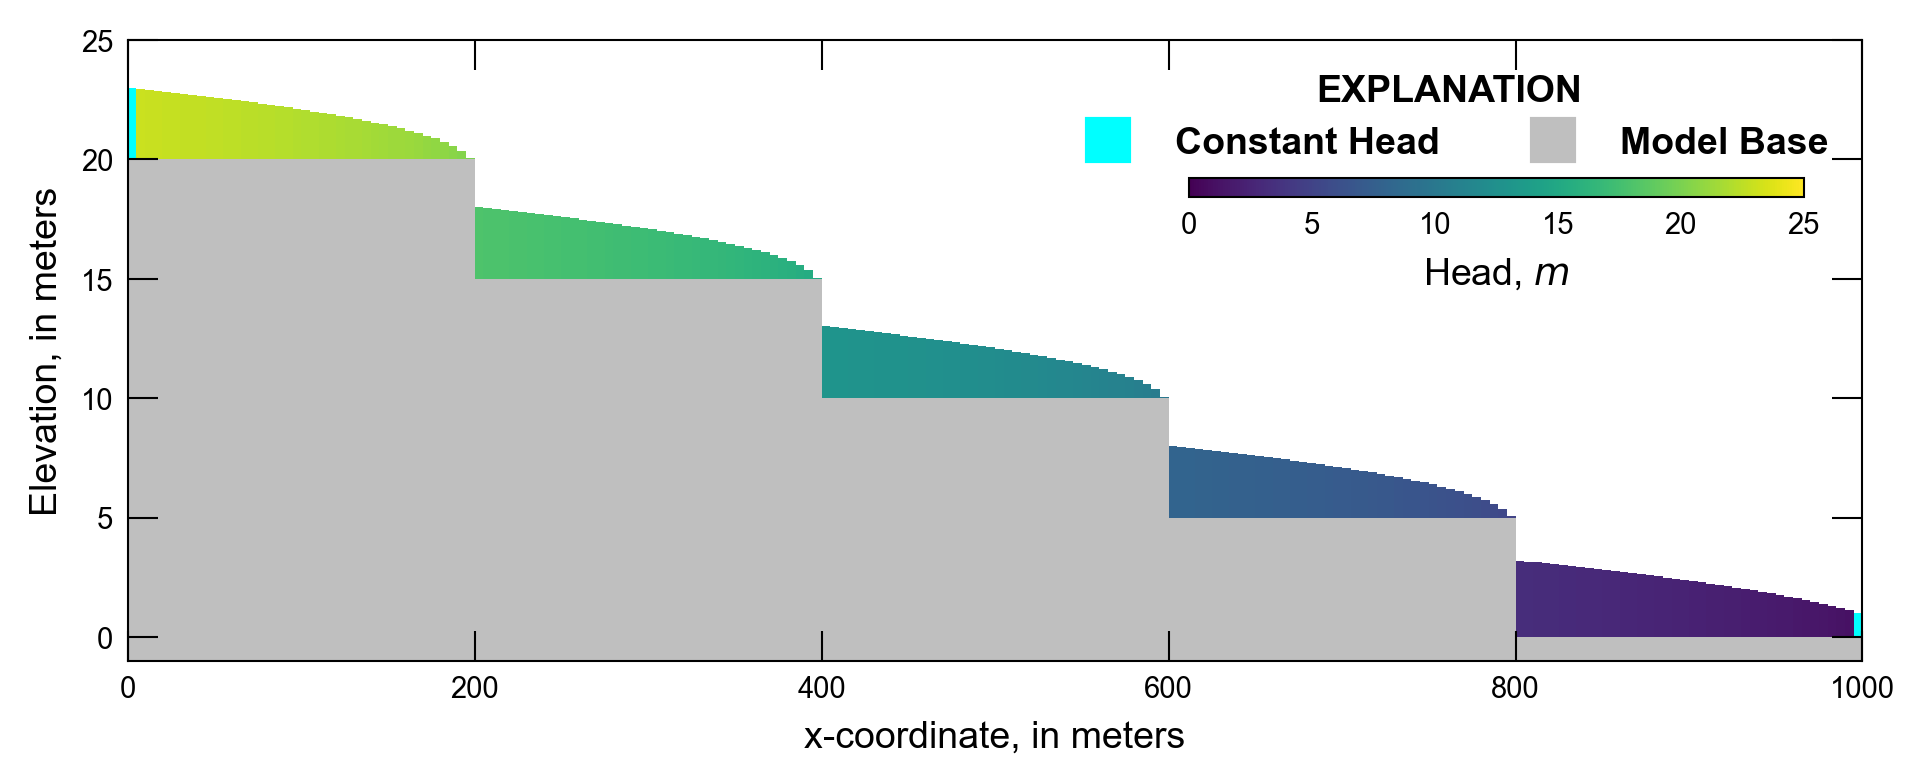

In [6]:
scenario(0)

Run the Zaidel model with H2 = 10, then plot simulated heads.

run_models took 28.91 ms


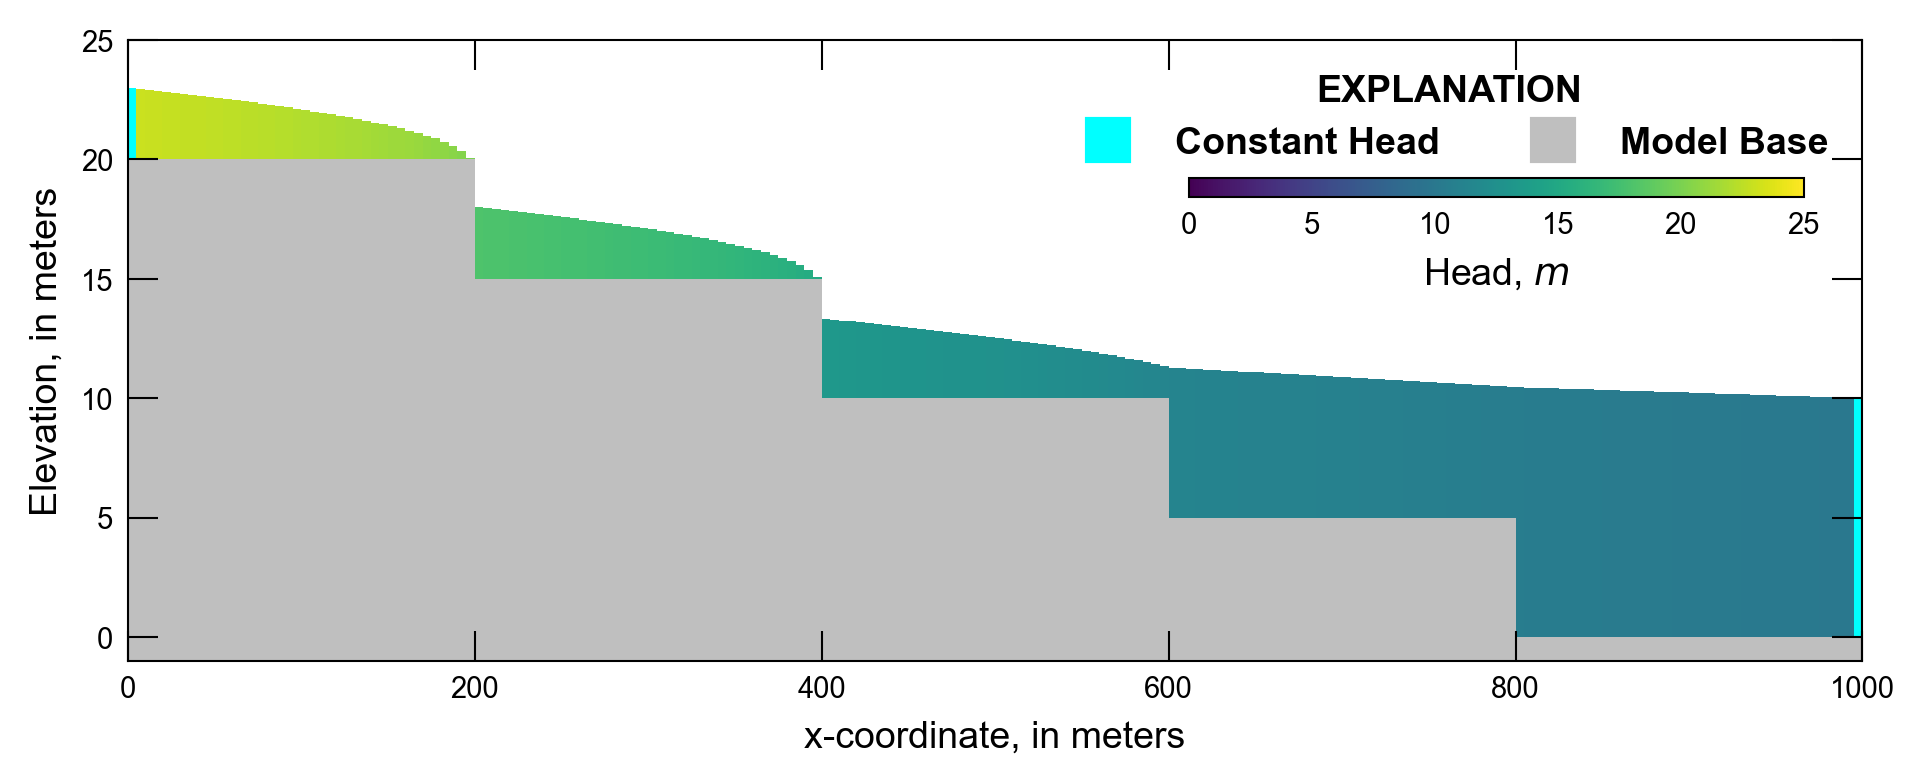

In [7]:
scenario(1)